In [1]:
# ================================================
# 数値計算・可視化・時系列分析ライブラリの読み込み
# ================================================

import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを適用

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

# 回帰分析や再帰予測を行うためのライブラリ
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

# ================================================
# グラフの日本語フォント設定
# ================================================
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"  # ← 正しいフォント名
rcParams["font.sans-serif"] = "Meiryo"  # 日本語をメイリオで表示

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# データの読み込み
ar_data = pd.read_csv(
    "4-2-1-ar-data.csv", index_col="date", parse_dates=True, dtype="float"
)

# 1日単位のデータ
ar_data.index.freq = "D"

# 先頭行の確認
print(ar_data.head(3))

                posi      nega
date                          
2023-01-01  1.788628 -0.231497
2023-01-02  1.867413  0.680778
2023-01-03  1.590428 -1.115185


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>],
      dtype=object)

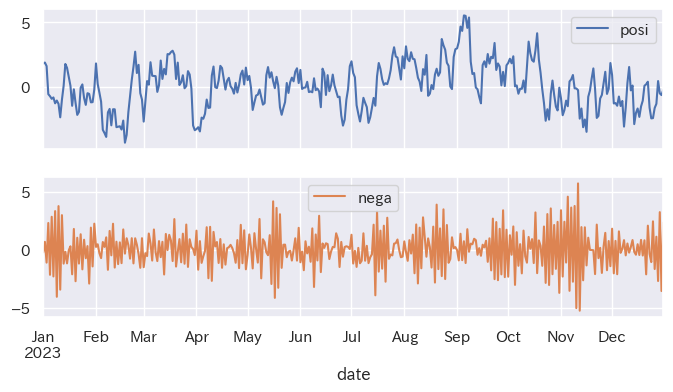

In [4]:
# 可視化
ar_data.plot(subplots=True)

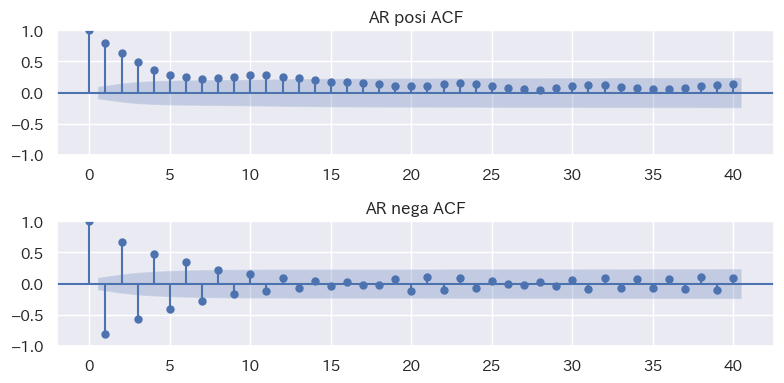

In [5]:
# =====================================================
# 自己回帰系列(AR)の自己相関を可視化するコレログラムの作成
# =====================================================

# グラフを縦に2分割（posi と nega を上下に表示）
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# -----------------------------------------------------
# 1. 正の自己相関（posi）のコレログラムを作成
# -----------------------------------------------------
#   - sm.graphics.tsa.plot_acf(): 自己相関関数 (ACF) を描画する関数
#   - lags=40: 最大で40時点先までの自己相関を表示
#   - title='AR posi ACF': グラフタイトル
#   - ax=ax[0]: 上段のグラフに描画
_ = sm.graphics.tsa.plot_acf(
    ar_data["posi"],  # 正の自己相関を持つAR系列
    lags=40,  # 最大ラグ数
    title="AR posi ACF",  # タイトル
    ax=ax[0],  # 上のグラフ領域
)

# -----------------------------------------------------
# 2. 負の自己相関（nega）のコレログラムを作成
# -----------------------------------------------------
#   - 正の自己相関とは逆に、符号が交互に変わるような波状の相関が現れる
_ = sm.graphics.tsa.plot_acf(
    ar_data["nega"],  # 負の自己相関を持つAR系列
    lags=40,  # 最大ラグ数
    title="AR nega ACF",  # タイトル
    ax=ax[1],  # 下のグラフ領域
)

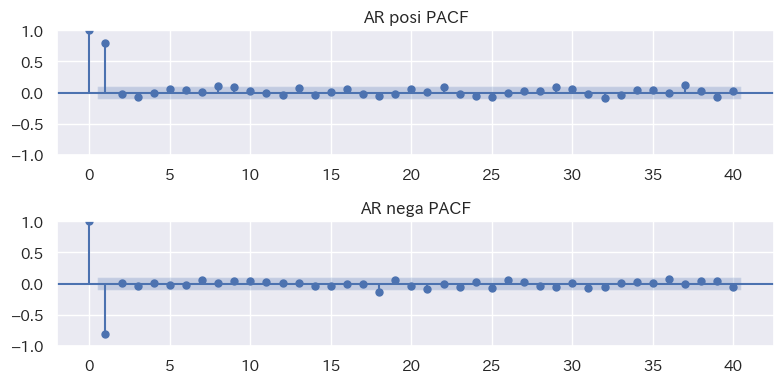

In [6]:
# =====================================================
# 部分自己相関 (PACF: Partial Autocorrelation Function)
# のコレログラムを作成して、AR(p) の次数構造を確認する
# =====================================================

# グラフサイズを指定（上下に2段配置）
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# -----------------------------------------------------
# 1. 正の自己相関を持つAR系列 (posi) のPACFプロット
# -----------------------------------------------------
# sm.graphics.tsa.plot_pacf():
#   部分自己相関を可視化する関数。
#   各ラグにおける「他のラグの影響を取り除いた純粋な自己相関」を表示。
#   → ARモデルの次数 p を特定するのに有効。
# lags=40: 最大で40時点先までの部分自己相関を表示。
# title: グラフのタイトル。
# ax=ax[0]: 上段のグラフに描画。
_ = sm.graphics.tsa.plot_pacf(
    ar_data["posi"],  # 正の自己相関を持つAR系列
    lags=40,  # 最大ラグ数
    title="AR posi PACF",  # タイトル
    ax=ax[0],  # 上のグラフ領域
)

# -----------------------------------------------------
# 2. 負の自己相関を持つAR系列 (nega) のPACFプロット
# -----------------------------------------------------
#   正の自己相関と異なり、負の自己相関では棒が上下交互に現れる傾向がある。
#   AR(1) の場合、ラグ1で強い自己相関が見られ、以降のラグでは急速に減衰。
_ = sm.graphics.tsa.plot_pacf(
    ar_data["nega"],  # 負の自己相関を持つAR系列
    lags=40,  # 最大ラグ数
    title="AR nega PACF",  # タイトル
    ax=ax[1],  # 下のグラフ領域
)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>],
      dtype=object)

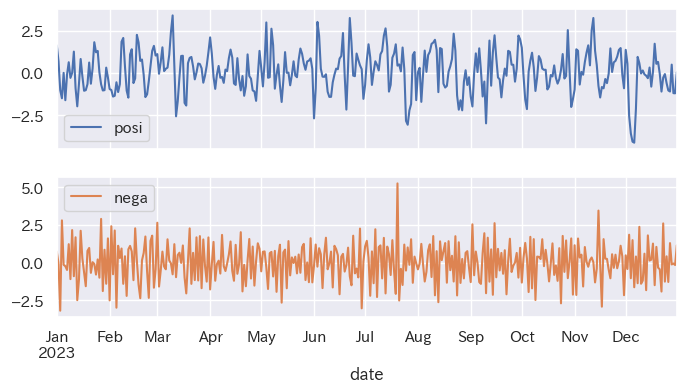

In [7]:
# データの読み込み
ma_data = pd.read_csv(
    "4-2-2-ma-data.csv", index_col="date", parse_dates=True, dtype="float"
)

# 1日単位のデータ
ma_data.index.freq = "D"

# 可視化
ma_data.plot(subplots=True)

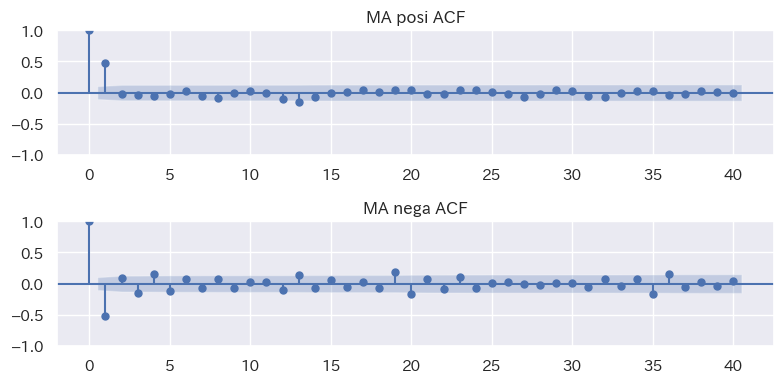

In [8]:
# =====================================================
# 移動平均過程（MAモデル）の自己相関構造を確認する
# =====================================================

# グラフサイズを指定（上下2段のサブプロット）
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# -----------------------------------------------------
# 1. 正の自己相関を持つ MA 系列の ACF（自己相関関数）を描画
# -----------------------------------------------------
# sm.graphics.tsa.plot_acf():
#   各ラグ（時系列の遅れ）に対する自己相関を計算して可視化する関数。
#   時系列が過去の値とどの程度似ているかを表す。
#   → MAモデルの次数 q を特定する際に有用。
# lags=40 : 最大で40時点先までの自己相関を表示。
# title : グラフタイトル。
# ax=ax[0] : 上段のグラフに描画。
_ = sm.graphics.tsa.plot_acf(
    ma_data["posi"],  # 正の自己相関を持つ MA 系列
    lags=40,  # 最大ラグ数
    title="MA posi ACF",  # タイトル
    ax=ax[0],  # 上のグラフ領域
)

# -----------------------------------------------------
# 2. 負の自己相関を持つ MA 系列の ACF を描画
# -----------------------------------------------------
#   負の自己相関を持つMAモデルでは、ラグ1付近でマイナスの自己相関が現れる。
#   MA(q)モデルでは、ACFがラグqで打ち切られる（**q次でカットオフ**）。
_ = sm.graphics.tsa.plot_acf(
    ma_data["nega"],  # 負の自己相関を持つ MA 系列
    lags=40,  # 最大ラグ数
    title="MA nega ACF",  # タイトル
    ax=ax[1],  # 下のグラフ領域
)

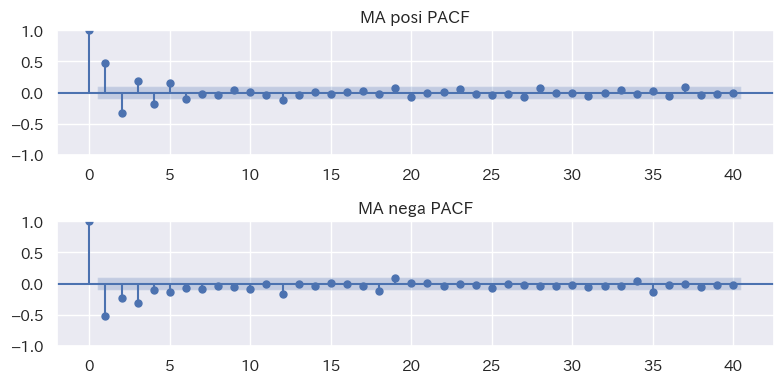

In [9]:
# =====================================================
# 移動平均過程（MAモデル）の偏自己相関構造を確認する
# =====================================================

# グラフサイズを指定（上下2段のサブプロットを作成）
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# -----------------------------------------------------
# 1. 正の自己相関を持つ MA 系列の PACF（偏自己相関関数）を描画
# -----------------------------------------------------
# sm.graphics.tsa.plot_pacf():
#   各ラグに対して「中間の影響を除いた純粋な相関」を示す関数。
#   ACFとは異なり、他のラグの影響を取り除いた「直接的な関係」を示す。
#   AR(p) モデルの次数 p を判断する際に重要。
#   一方で、MA(q)モデルでは PACF が指数的に減衰していくのが特徴。
#
# lags=40 : 最大ラグ数（過去40時点までを表示）
# title : グラフタイトル
# ax=ax[0] : 上のサブプロットに描画
_ = sm.graphics.tsa.plot_pacf(
    ma_data["posi"],  # 正の自己相関を持つ MA 系列
    lags=40,  # 最大ラグ数
    title="MA posi PACF",  # グラフタイトル
    ax=ax[0],  # 上段のグラフ
)

# -----------------------------------------------------
# 2. 負の自己相関を持つ MA 系列の PACF を描画
# -----------------------------------------------------
#   MAモデルでは、PACFは**徐々に減衰していく（tail off）**ことが特徴。
#   これに対して、ARモデルでは PACF が次数 p で**カットオフ**される。
#
#   よって、PACFの減衰具合を観察することで、
#   ARモデルかMAモデルかの識別に利用できる。
_ = sm.graphics.tsa.plot_pacf(
    ma_data["nega"],  # 負の自己相関を持つ MA 系列
    lags=40,  # 最大ラグ数
    title="MA nega PACF",  # グラフタイトル
    ax=ax[1],  # 下段のグラフ
)

In [10]:
# 参考：分析の対象となるデータ
ar_data["posi"].head(3)

date
2023-01-01    1.788628
2023-01-02    1.867413
2023-01-03    1.590428
Freq: D, Name: posi, dtype: float64

In [11]:
# ラグデータの作成
# tsa.lagmat() は、時系列データに指定したラグ（過去の値）を付与する関数
#   maxlag=1 → 1期前のデータを作る
#   original='in' → 元のデータ列（当期データ）も含める
#   use_pandas=True → 結果を pandas.DataFrame で返す
ar_lag = tsa.lagmat(ar_data["posi"], maxlag=1, original="in", use_pandas=True)

# 列名の変更
# lagmat() の出力列名は単純な整数になるため、わかりやすく変更
ar_lag.columns = ["target", "lag1"]

# 最初の1行を削除
# 1期前のデータが存在しない最初の行（NaN）を除去する
ar_lag = ar_lag.iloc[1:, :]

# 結果の確認
# target列 → 当期の値
# lag1列   → 1期前の値（説明変数）
print(ar_lag.head(3))

              target      lag1
date                          
2023-01-02  1.867413  1.788628
2023-01-03  1.590428  1.867413
2023-01-04 -0.591151  1.590428


In [12]:
# ================================================
# AR(1) モデル（自己回帰モデル）の構築と推定
# ================================================

# smf.ols(): 最小二乗法による線形回帰モデルを構築
# ここでは自己回帰モデル AR(1) の形に対応する：
#   y_t = β0 + β1 * y_{t-1} + ε_t
#
# formula='target ~ lag1' は
#   目的変数 target（= y_t）
#   説明変数 lag1（= y_{t-1}）
# の関係を表す。
ar_ols = smf.ols(formula="target ~ lag1", data=ar_lag).fit()

# ================================================
# 推定されたパラメータの表示
# ================================================
#   Intercept：切片（β₀）
#   lag1     ：1期前の自己回帰係数（β₁）
# ================================================
ar_ols.params

Intercept    0.001189
lag1         0.802707
dtype: float64

In [13]:
# ================================================
# AutoReg（自己回帰モデル）の自動推定
# ================================================

# tsa.AutoReg():
#   statsmodels の自己回帰モデル（ARモデル）を構築するクラス。
#   ここではラグ1（1期前）までを説明変数とする AR(1) モデルを指定。
#
#   モデル式：
#       y_t = c + φ₁ * y_{t-1} + ε_t
#
# fit():
#   パラメータ（c, φ₁）を最小二乗法で推定。
# ================================================

ar_autoreg = tsa.AutoReg(ar_data["posi"], lags=1).fit()

# ================================================
# 推定されたパラメータの表示
#   const ：定数項 c
#   y.L1  ：ラグ1の係数 φ₁
# ================================================
ar_autoreg.params

const      0.001189
posi.L1    0.802707
dtype: float64

In [14]:
# ================================================
# 再帰的予測モデル（Recursive Regression）
# ================================================

# regressor:
#   線形回帰モデル（scikit-learnのLinearRegression）を予測器として使用。
#
# make_reduction():
#   sktimeの関数で、回帰モデルを時系列予測モデルに変換する。
#   window_length=1 → 1期前のデータを説明変数として利用（AR(1)に相当）
#   strategy="recursive" → 予測値を次期の入力として再帰的に使用。
#
# fit():
#   訓練データ（ar_data['posi']）に基づいてモデルを学習。
# ================================================

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=1, strategy="recursive")
forecaster.fit(ar_data["posi"])

# ================================================
# 推定されたパラメータの確認
#  'intercept'：定数項 c
#  'regressor__coef_'：自己回帰係数 φ₁
# ================================================
forecaster.get_fitted_params()

{'estimator': LinearRegression(),
 'transformers': None,
 'window_length': 1,
 'estimator__coef': array([0.80270658]),
 'estimator__intercept': 0.0011885023794679615,
 'estimator__n_features_in': 1,
 'estimator__rank': 1,
 'estimator__singular': array([33.33510614])}

In [15]:
# ================================================
# 状態空間モデル（State Space Model）によるAR(1)推定
# ================================================

# SARIMAX():
#   statsmodelsの汎用的な時系列モデルクラス。
#   ARIMA(p, d, q) モデルや状態空間モデル（SSM）を表現できる。
#
# order=(1, 0, 0) → AR(1) モデルを意味する。
#   p = 1：自己回帰の次数（AR項）
#   d = 0：差分次数（非定常成分なし）
#   q = 0：移動平均の次数（MA項なし）
#
# trend='c' → 定数項（constant）を含める。
#
# fit():
#   最尤法（MLE: Maximum Likelihood Estimation）でパラメータを推定。
# ================================================

mod_ar = tsa.SARIMAX(ar_data["posi"], order=(1, 0, 0), trend="c").fit()

# ================================================
# 推定されたパラメータの確認
#  'ar.L1' ：自己回帰係数 φ₁
#  'sigma2'：誤差分散 σ²
#  'intercept'：定数項 c
# ================================================
mod_ar.params

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45777D+00    |proj g|=  8.16574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   1.143D-05   1.458D+00
  F =   1.4577334878554420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


intercept    0.009795
ar.L1        0.802726
sigma2       1.077611
dtype: float64

In [16]:
# ================================================
# 状態空間モデル（State Space Model）による MA(1) 推定
# ================================================

# SARIMAX():
#   ARIMAやMAモデルを含む一般的な時系列モデルを推定できる。
#
# order=(0, 0, 1) → MA(1) モデルを意味する。
#   p = 0：自己回帰項なし
#   d = 0：差分なし（定常）
#   q = 1：移動平均項を1次まで考慮
#
# trend='c' → 定数項（平均レベル）を含む。
#
# fit():
#   最尤法（MLE: Maximum Likelihood Estimation）でパラメータを推定。
# ================================================

mod_ma = tsa.SARIMAX(ma_data["posi"], order=(0, 0, 1), trend="c").fit()

# ================================================
# 推定されたパラメータの確認
#  'ma.L1' ：移動平均係数 θ₁
#  'sigma2'：誤差分散 σ²
#  'intercept'：定数項 c
# ================================================
mod_ma.params

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38005D+00    |proj g|=  5.35087D-02

At iterate    5    f=  1.37337D+00    |proj g|=  9.63275D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   7.658D-06   1.373D+00
  F =   1.3733726583051891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


intercept    0.098855
ma.L1        0.775439
sigma2       0.910584
dtype: float64

In [17]:
# 推定されたパラメータ
ar_ols.params

Intercept    0.001189
lag1         0.802707
dtype: float64

In [18]:
# ================================================
# AR(1)モデルによる1期先予測
# ================================================

# 予測式：
#   ŷ_{t+1} = β₀ + β₁ * y_t
#
# ar_ols.params.iloc[0] → 切片（β₀）
# ar_ols.params.iloc[1] → 回帰係数（β₁ = φ₁）
# ar_data['posi'].tail(1).values → 最新の観測値（y_t）
#
# よって、1期先の予測値 ŷ_{t+1} は以下のように求められる：
# ================================================

ar_pred_1 = (
    ar_ols.params.iloc[0]  # 定数項 β₀
    + ar_ols.params.iloc[1] * ar_data["posi"].tail(1).values  # φ₁ * y_t
)

print(ar_pred_1)

[-0.2189263]


In [19]:
# 2時点先以降の予測
ar_pred_2 = ar_ols.params.iloc[0] + ar_ols.params.iloc[1] * ar_pred_1
ar_pred_3 = ar_ols.params.iloc[0] + ar_ols.params.iloc[1] * ar_pred_2

print(ar_pred_2)
print(ar_pred_3)

[-0.17454508]
[-0.13891998]


In [20]:
# ================================================
# AutoRegモデルによる3期先予測
# ================================================

# AR(1)モデルの一般形：
#   y_t = c + φ₁ y_{t-1} + ε_t
#
# これをもとに、学習済みモデル（ar_autoreg）を用いて
# 3期先までの予測を実施する。
# ================================================

ar_autoreg.forecast(3)

2024-01-01   -0.218926
2024-01-02   -0.174545
2024-01-03   -0.138920
Freq: D, dtype: float64

In [21]:
# ================================================
# sktime による再帰的予測
# ================================================

# 予測ホライズン（forecast horizon）を指定：
#   → 今回は 1期先, 2期先, 3期先 の3つを予測する
# fh = np.arange(1, 4) は [1, 2, 3] を意味する
# ================================================

forecaster.predict(fh=np.arange(1, 4))

2024-01-01   -0.218926
2024-01-02   -0.174545
2024-01-03   -0.138920
Freq: D, Name: posi, dtype: float64

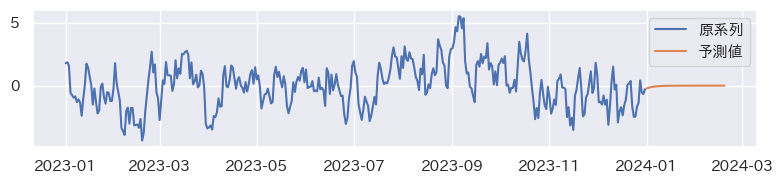

In [22]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# 原系列の折れ線グラフ
ax.plot(ar_data["posi"], label="原系列")

# 予測値の折れ線グラフ
ax.plot(ar_autoreg.forecast(50), label="予測値")

# 凡例
ax.legend()

In [23]:
# ================================================
# MA(1)モデル（Moving Average Model）の推定結果確認
# ================================================

# 状態空間表現（State Space Model）で表した MA(1) モデルの推定パラメータを出力
# ここでのモデル式は以下の通り：
#     y_t = μ + ε_t + θ₁ ε_{t-1}
# --------------------------------
# μ  ：定数項（平均レベル）
# θ₁：MA(1)項の係数（直前の誤差の影響度）
# ε_t：ホワイトノイズ
# --------------------------------

mod_ma.params

intercept    0.098855
ma.L1        0.775439
sigma2       0.910584
dtype: float64

In [24]:
# ================================================
# 最終日の残差（予測誤差）の算出
# ================================================

# 残差（residual）とは：
#     ε_t = 実測値 − 当てはめ値（予測値）
#
# ここでは MA(1) モデル（mod_ma）によって推定された
# fittedvalues（当てはめ値）を用いて、
# 最終観測点における残差 ε_T を計算している。
# ================================================

ma_data["posi"].tail(1) - mod_ma.fittedvalues.tail(1)

date
2023-12-31   -0.229561
Freq: D, dtype: float64

In [25]:
# ================================================
# 最終日の残差を直接取得
# ================================================

# SARIMAX（状態空間モデル）では、残差（resid）はモデル内部で自動的に計算されている。
# ここでは、最終時点（T）の残差 ε_T を直接取り出している。
#
# 残差の定義：
#     ε_t = y_t − ŷ_t
#
# モデルにおける役割：
#     MA(1) モデルでは、次期の予測に ε_t が再利用される。
#     具体的には、
#         ŷ_{t+1} = μ + θ₁ ε_t
# ================================================

mod_ma.resid.tail(1)

date
2023-12-31   -0.229561
Freq: D, dtype: float64

In [26]:
# ================================================
# 翌日の予測値（MA(1)モデルによる1期先予測）
# ================================================

# MA(1)モデルの定義式：
#     y_t = μ + ε_t + θ₁ ε_{t-1}
#
# 1期先予測では、まだ ε_{t+1} は観測できないため、
#     E[ε_{t+1}] = 0 と仮定し、
# 予測式は次のように簡略化される：
#     ŷ_{t+1} = μ + θ₁ ε_t
#
# ここで：
#     μ   → 切片（平均項）
#     θ₁  → 移動平均係数
#     ε_t → 最終時点（t=T）の残差
# ================================================

mod_ma.params.iloc[0] + mod_ma.params.iloc[1] * mod_ma.resid.tail(1).values

array([-0.079155])

In [27]:
mod_ma.forecast(3)

2024-01-01   -0.079155
2024-01-02    0.098855
2024-01-03    0.098855
Freq: D, Name: predicted_mean, dtype: float64

<Axes: xlabel='date'>

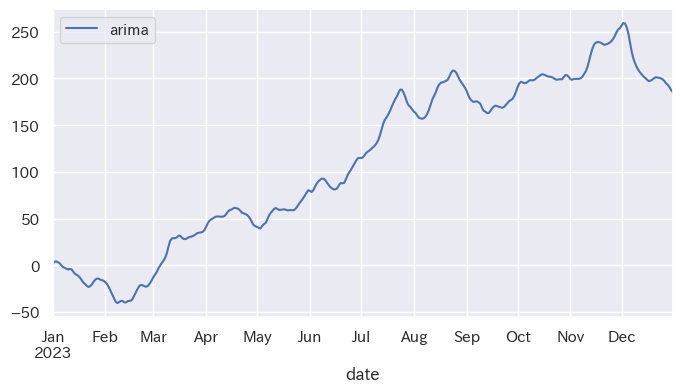

In [28]:
# データの読み込み
arima_data = pd.read_csv(
    "4-2-3-arima-data.csv", index_col="date", parse_dates=True, dtype="float"
)

# 1日単位のデータ
arima_data.index.freq = "D"

# 可視化
arima_data.plot()

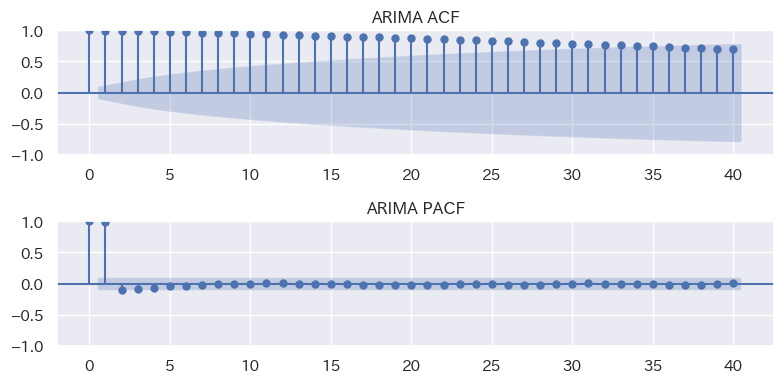

In [29]:
# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# コレログラムの作成
_ = sm.graphics.tsa.plot_acf(arima_data, lags=40, title="ARIMA ACF", ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(arima_data, lags=40, title="ARIMA PACF", ax=ax[1])

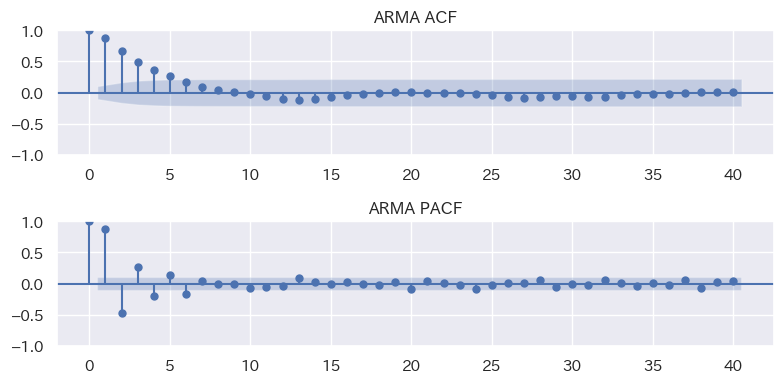

In [30]:
# ================================================
# ARMAモデルの自己相関・偏自己相関の確認
# ================================================

# 差分をとることで非定常性を除去し、ARMAモデルに適したデータへ変換
arma_data = arima_data.diff().iloc[1:, :]  # 1階差分を取り、最初のNaNを除去

# グラフサイズの指定
fig, ax = plt.subplots(2, 1, figsize=(8, 4), tight_layout=True)

# ACF（自己相関関数）プロット
# → 各ラグにおける系列の自己相関を確認し、MA成分の有無を把握
_ = sm.graphics.tsa.plot_acf(arma_data, lags=40, title="ARMA ACF", ax=ax[0])

# PACF（偏自己相関関数）プロット
# → 他のラグの影響を除いた純粋な相関を確認し、AR成分の次数を推定
_ = sm.graphics.tsa.plot_pacf(arma_data, lags=40, title="ARMA PACF", ax=ax[1])

In [31]:
# ================================================
# ARIMA(1,1,1)モデルの構築とパラメータ推定
# ================================================

# 状態空間モデル（State Space Model）を用いたARIMAモデルの推定
# order=(1, 1, 1) → AR(1)・1階差分・MA(1)を意味する
# trend='c' は定数項（切片）を含むモデルを指定
mod_arima = tsa.SARIMAX(arima_data, order=(1, 1, 1), trend="c").fit()

# 推定されたパラメータを表示
mod_arima.params

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38460D+00    |proj g|=  7.84657D-02

At iterate    5    f=  1.36957D+00    |proj g|=  6.36080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   6.508D-06   1.370D+00
  F =   1.3695660933517106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


intercept    0.110056
ar.L1        0.772905
ma.L1        0.788230
sigma2       0.905733
dtype: float64

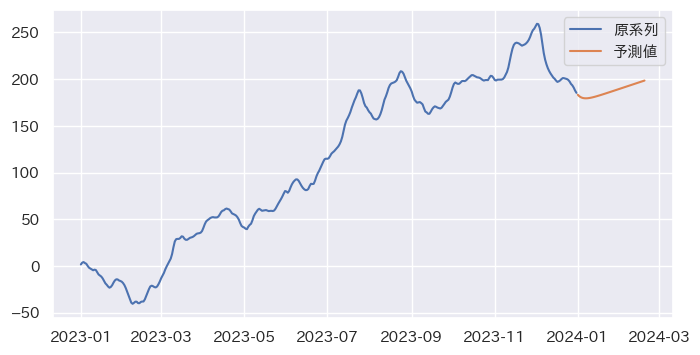

In [32]:
# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 原系列の折れ線グラフ
ax.plot(arima_data, label="原系列")

# 予測値の折れ線グラフ
ax.plot(mod_arima.forecast(50), label="予測値")

# 凡例
ax.legend()